### HCR using LeNet

Inspired by: **Recognition of Handwritten Characters using
Deep Convolutional Neural Network** paper of Jagan Mohan Reddy D, A Vishnuvardhan Reddy

In [9]:
import numpy as np 
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
from random import randint

In [11]:
import cv2
from google.colab.patches import cv2_imshow

In [12]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import ZeroPadding2D, BatchNormalization, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Add

In [13]:
keras.backend.image_data_format()
keras.backend.set_image_data_format('channels_last')

In [14]:
import tensorflow as tf

In [15]:
X_FNAME = "/content/alphanum-hasy-data-X.npy"
Y_FNAME = "/content/alphanum-hasy-data-y.npy"
SYMBOL_FNAME = "/content/symbols.csv"

In [16]:
X = np.load(X_FNAME)
y = np.load(Y_FNAME)
SYMBOLS = pd.read_csv(SYMBOL_FNAME) 
SYMBOLS = SYMBOLS[["symbol_id", "latex"]]

print("X.shape", X.shape)
print("y.shape", y.shape)
print("SYMBOLS")
SYMBOLS.head(2)

X.shape (4658, 32, 32)
y.shape (4658,)
SYMBOLS


,symbol_id,latex
0,31,A
1,32,B


<h1> Analysing the data

In [17]:
def symbol_id_to_symbol(symbol_id = None):
    if symbol_id:
        symbol_data = SYMBOLS.loc[SYMBOLS['symbol_id'] == symbol_id]
        if not symbol_data.empty:
            return str(symbol_data["latex"].values[0])
        else:
            print("This should not have happend, wrong symbol_id = ", symbol_id)
            return None
    else: 
        print("This should not have happend, no symbol id passed")
        return None        

# test some values
print("21 = ", symbol_id_to_symbol(21))
print("32 = ", symbol_id_to_symbol(32))
print("90 = ", symbol_id_to_symbol(90))

This should not have happend, wrong symbol_id =  21
21 =  None
32 =  B
90 =  a


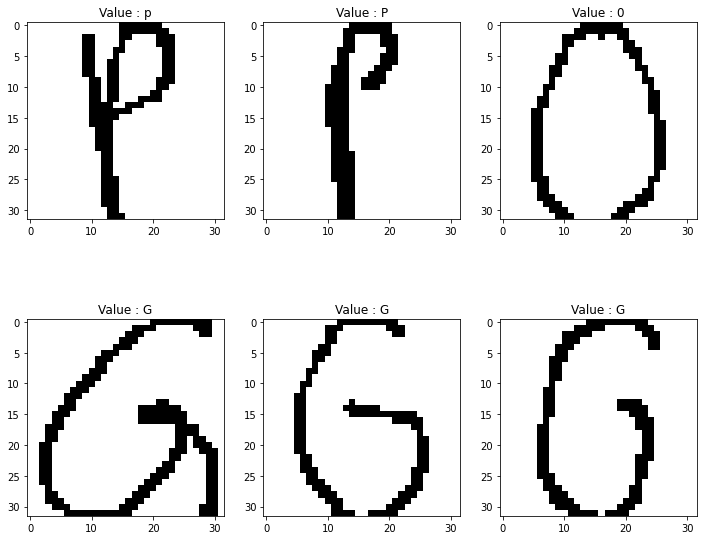

In [18]:
f, ax = plt.subplots(2, 3, figsize=(12, 10))
ax_x = 0
ax_y = 0

for i in range(6):
    randKey = randint(0, X.shape[0])
    ax[ax_x, ax_y].imshow(X[randKey], cmap='gray')
    ax[ax_x, ax_y].title.set_text("Value : " + symbol_id_to_symbol(y[randKey]))

    # for proper subplots
    if ax_x == 1:
        ax_x = 0
        ax_y = ax_y + 1
    else:
        ax_x = ax_x + 1

In [19]:
# print labels vs frequency matrix
unique, counts = np.unique(y, return_counts=True)
y_info_dict = { "labels" : unique, "counts": counts }
y_info_frame = pd.DataFrame(y_info_dict)

y_info_frame["labels"] = y_info_frame["labels"].apply(lambda x: symbol_id_to_symbol(x))
y_info_frame.head()

,labels,counts
0,A,159
1,B,61
2,C,134
3,D,58
4,E,54


In [20]:
y_info_frame.shape

(61, 2)

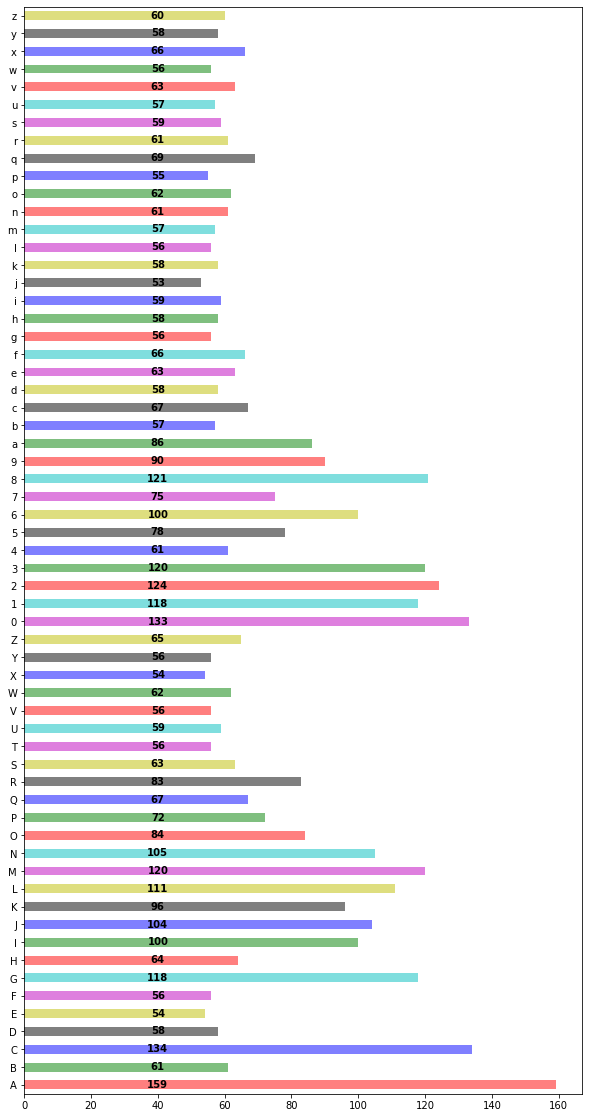

In [21]:
f, ax = plt.subplots(figsize=(10, 20))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
y_info_frame["counts"].plot(kind='barh', legend=False, color=my_colors, alpha=0.5)
wrap = ax.set_yticklabels(list(y_info_frame["labels"]))

rects = ax.patches
bar_labels_counts = list(y_info_frame["counts"])

for i in range(len(bar_labels_counts)):
    label_value = str(bar_labels_counts[i])
    ax.text(40, rects[i].get_y(), label_value, ha='center',
          va='bottom', size='medium', color="black", fontweight="bold")

<h1> Pre processing data </h1>

In [22]:
X.shape ## already in 32*32 shape

(4658, 32, 32)

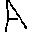

In [23]:
cv2_imshow(X[0])

In [24]:
X = X / 255.0 ## normalize

In [25]:
np.unique(y)

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 110, 111, 112, 113, 114, 115])

In [26]:
y_new = [] ## getting the values of y in the range of 0-61
for val in y:
  if val >=31 and val <=56:
    val = val-31
    y_new.append(val)
  elif val >=70 and val <=79:
    val = val-44
    y_new.append(val)
  else:
    val = val-54 
    y_new.append(val)

In [27]:
y_n = np.array(y_new)

In [28]:
y_n.shape

(4658,)

In [29]:
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_n, num_classes=62)

print("Shape of y:", y_onehot.shape)
print("One value of y:", y_onehot[0])

Shape of y: (4658, 62)
One value of y: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)

print("Train dataset shape")
print(X_train.shape, y_train.shape)
print("Test dataset shape")
print(X_test.shape, y_test.shape)

Train dataset shape
(3726, 32, 32) (3726, 62)
Test dataset shape
(932, 32, 32) (932, 62)


In [31]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1) #grayscale
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

<h1> LeNet-5 model </h1>

In [32]:
np.random.seed(0)

In [33]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=62, activation = 'softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               155640    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [35]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [36]:
history = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 25)

Epoch 1/25
117/117 [==============================] - 2s 21ms/step - loss: 3.6934 - accuracy: 0.1154
Epoch 2/25
117/117 [==============================] - 2s 21ms/step - loss: 2.0881 - accuracy: 0.4117
Epoch 3/25
117/117 [==============================] - 3s 21ms/step - loss: 1.4168 - accuracy: 0.5776
Epoch 4/25
117/117 [==============================] - 3s 22ms/step - loss: 1.0949 - accuracy: 0.6490
Epoch 5/25
117/117 [==============================] - 3s 22ms/step - loss: 0.9124 - accuracy: 0.7024
Epoch 6/25
117/117 [==============================] - 3s 22ms/step - loss: 0.7977 - accuracy: 0.7220
Epoch 7/25
117/117 [==============================] - 2s 21ms/step - loss: 0.6985 - accuracy: 0.7606
Epoch 8/25
117/117 [==============================] - 3s 23ms/step - loss: 0.6120 - accuracy: 0.7848
Epoch 9/25
117/117 [==============================] - 3s 22ms/step - loss: 0.5606 - accuracy: 0.7925
Epoch 10/25
117/117 [==============================] - 3s 22ms/step - loss: 0.4941 - accura

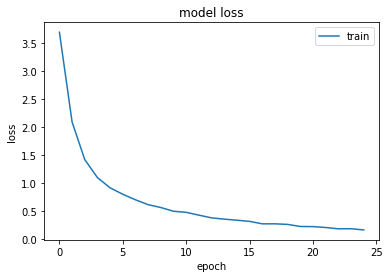

In [37]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

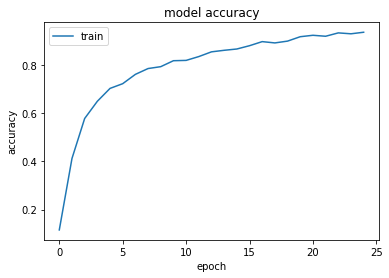

In [38]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [39]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 8ms/step - loss: 1.2421 - accuracy: 0.7210


[1.2420803308486938, 0.721030056476593]

### Using Simulated Annealing 

A metaheuristic optimization technique

Reference: **Multi-font Optical Character Recognition Using
Deep Learning** written by P.K. Sandhya Balakrishnan, L. Pavithira

In [40]:
def simulated_annealing(y_pred, label):
  return 0.5 * tf.math.pow(tf.reduce_mean(tf.square(tf.subtract(y_pred, label))), 0.5)

In [41]:
model.compile(loss=simulated_annealing, metrics=["accuracy"], optimizer="adam")

In [42]:
history = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 25)

Epoch 1/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0204 - accuracy: 0.9238
Epoch 2/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0204 - accuracy: 0.9227
Epoch 3/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0200 - accuracy: 0.9316
Epoch 4/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0200 - accuracy: 0.9219
Epoch 5/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0193 - accuracy: 0.9329
Epoch 6/25
117/117 [==============================] - 2s 20ms/step - loss: 0.0195 - accuracy: 0.9318
Epoch 7/25
117/117 [==============================] - 2s 20ms/step - loss: 0.0186 - accuracy: 0.9372
Epoch 8/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0188 - accuracy: 0.9337
Epoch 9/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0182 - accuracy: 0.9426
Epoch 10/25
117/117 [==============================] - 2s 21ms/step - loss: 0.0181 - accura

In [43]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 8ms/step - loss: 0.0434 - accuracy: 0.7124


[0.043399594724178314, 0.7124463319778442]

### Adding a dropout layer

In [44]:
model_dropout = Sequential()
model_dropout.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_dropout.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model_dropout.add(Dropout(rate=0.1))
model_dropout.add(Flatten())
model_dropout.add(Dense(units=120, activation='relu'))
model_dropout.add(Dense(units=84, activation='relu'))
model_dropout.add(Dense(units=62, activation = 'softmax'))

In [45]:
model_dropout.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [46]:
history = model_dropout.fit(x = X_train, y = y_train, batch_size = 16, epochs = 25)

Epoch 1/25
233/233 [==============================] - 3s 13ms/step - loss: 3.2197 - accuracy: 0.2077
Epoch 2/25
233/233 [==============================] - 3s 13ms/step - loss: 1.4906 - accuracy: 0.5529
Epoch 3/25
233/233 [==============================] - 3s 13ms/step - loss: 1.0110 - accuracy: 0.6771
Epoch 4/25
233/233 [==============================] - 3s 13ms/step - loss: 0.7809 - accuracy: 0.7364
Epoch 5/25
233/233 [==============================] - 3s 13ms/step - loss: 0.6566 - accuracy: 0.7746
Epoch 6/25
233/233 [==============================] - 3s 13ms/step - loss: 0.5493 - accuracy: 0.8001
Epoch 7/25
233/233 [==============================] - 3s 13ms/step - loss: 0.4788 - accuracy: 0.8191
Epoch 8/25
233/233 [==============================] - 3s 13ms/step - loss: 0.4251 - accuracy: 0.8403
Epoch 9/25
233/233 [==============================] - 3s 13ms/step - loss: 0.3567 - accuracy: 0.8647
Epoch 10/25
233/233 [==============================] - 3s 13ms/step - loss: 0.3133 - accura

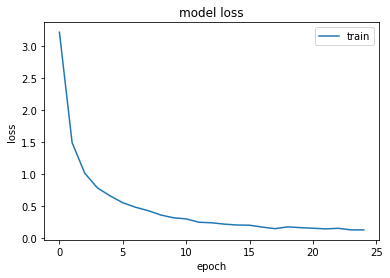

In [47]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

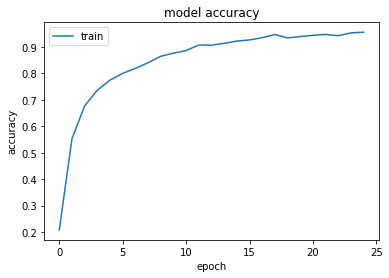

In [48]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [49]:
model_dropout.evaluate(X_test, y_test) ## accuracy increased

30/30 [==============================] - 0s 8ms/step - loss: 1.2370 - accuracy: 0.7318


[1.237007975578308, 0.7317596673965454]

<h1> Using RESNET-50 </h1>

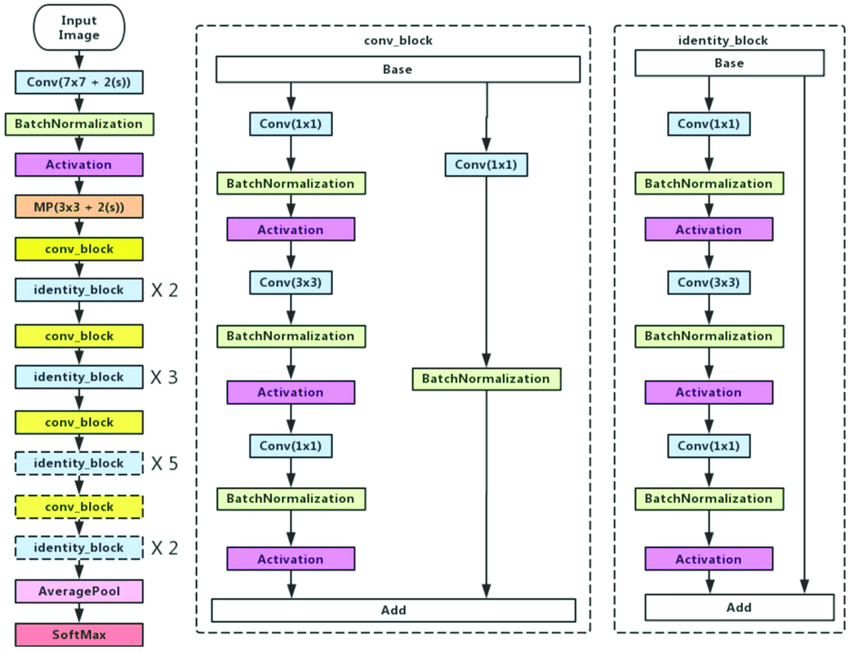

In [50]:
def identity_block(X, f, filters):
 
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
      
    return X

In [51]:
def convolutional_block(X, f, filters, s):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [52]:
def ResNet50(input_shape, classes):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    print('stage 1 done')
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    print('stage 2 done')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    print('stage 3 done')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    print('stage 4 done')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    print('stage 5 done')

    # AVGPOOL 
    X = AveragePooling2D(padding="same")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [53]:
model_resnet50 = ResNet50(input_shape = (32, 32, 1), classes = 62)

stage 1 done
stage 2 done
stage 3 done
stage 4 done
stage 5 done


In [54]:
model_resnet50.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [55]:
history = model_resnet50.fit(x = X_train, y = y_train, batch_size = 32, epochs = 12)

Epoch 1/12
117/117 [==============================] - 250s 2s/step - loss: 3.9604 - accuracy: 0.2614
Epoch 2/12
117/117 [==============================] - 252s 2s/step - loss: 2.1429 - accuracy: 0.5274
Epoch 3/12
117/117 [==============================] - 248s 2s/step - loss: 1.5338 - accuracy: 0.6388
Epoch 4/12
117/117 [==============================] - 241s 2s/step - loss: 1.4322 - accuracy: 0.6498
Epoch 5/12
117/117 [==============================] - 241s 2s/step - loss: 1.0073 - accuracy: 0.7534
Epoch 6/12
117/117 [==============================] - 246s 2s/step - loss: 0.9683 - accuracy: 0.7708
Epoch 7/12
117/117 [==============================] - 247s 2s/step - loss: 1.8115 - accuracy: 0.6178
Epoch 8/12
117/117 [==============================] - 253s 2s/step - loss: 1.1741 - accuracy: 0.7300
Epoch 9/12
117/117 [==============================] - 255s 2s/step - loss: 1.0618 - accuracy: 0.7469
Epoch 10/12
117/117 [==============================] - 257s 2s/step - loss: 0.6898 - accura

In [56]:
model_resnet50.evaluate(X_test, y_test)

30/30 [==============================] - 3s 112ms/step - loss: 2.6068 - accuracy: 0.5300


[2.6067960262298584, 0.5300429463386536]

<h1> Using VGG-16 </h1>

In [57]:
model_vgg = Sequential()
model_vgg.add(ZeroPadding2D((1,1),input_shape=(32,32,1)))
model_vgg.add(Conv2D(64, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(64, (3, 3), activation='relu'))
model_vgg.add(MaxPooling2D((2,2), strides=(2,2)))

model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(128, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(128, (3, 3), activation='relu'))
model_vgg.add(MaxPooling2D((2,2), strides=(2,2)))

model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(256, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(256, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(256, (3, 3), activation='relu'))
model_vgg.add(MaxPooling2D((2,2), strides=(2,2)))

model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(MaxPooling2D((2,2), strides=(2,2)))

model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(ZeroPadding2D((1,1)))
model_vgg.add(Conv2D(512, (3, 3), activation='relu'))
model_vgg.add(MaxPooling2D((2,2), strides=(2,2)))

model_vgg.add(Flatten())
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(62, activation='softmax'))

In [58]:
model_vgg.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
history = model_vgg.fit(x = X_train, y = y_train, batch_size = 32, epochs = 5)